In [30]:
import numpy as np

from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import pandas as pd

In [16]:
#load dataframe from csv
demographics_data = pd.read_csv("data/newdata/2018_demographic_data_edited.csv", delimiter=',')
print(demographics_data.shape)
demographics_data = demographics_data.drop(columns=["Geo_ZCTA5", "Geo_ZCTA3", "Geo_LOGRECNO", "Geo_GEOCOMP", "Geo_SUMLEV"])

(33120, 2151)


In [17]:
null_counts = demographics_data.isnull().sum()
print(null_counts[null_counts > 0])

SE_A01004_001      564
SE_A01004_002      843
SE_A01004_003      897
SE_A10003_001      726
SE_A10003B_001    2496
                  ... 
SE_A13007_009       35
SE_A13007_010       35
SE_A13007_011       35
SE_A10064_001       35
SE_A10064_002       35
Length: 870, dtype: int64


In [18]:
# drop any column with missing values greater than 5%
demographics_data.drop(columns=["SE_A18007_006","SE_A18007_007","SE_A18007_005","SE_A18007_004",
                     "SE_A18007_003","SE_A18007_002","SE_A18008_011",
                     "SE_A18008_010","SE_A18008_009","SE_A18010_002",
                     "SE_A18010_003","SE_A18010_004","SE_A18010_005",
                     "SE_A18010_006","SE_A18010_007","SE_A18008_001","SE_A18008_002",
                     "SE_A18008_003","SE_A18008_008","SE_A18008_007","SE_A18008_006","SE_A18008_005",
                     "SE_A18008_004"], axis=1, inplace=True)

Ok, maybe all along we've been picking bad datapoints to look at, lets just Gini index, Average household income, and rent as a percentage of income.

C:\Users\winbase\Anaconda3\envs\mids\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\winbase\Anaconda3\envs\mids\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\winbase\Anaconda3\envs\mids\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy

SE_A14028_001           948
SE_A14011_001          1662
vacancy_rate            490
income_to_homevalue    2670
renters_pct             490
dtype: int64
(30450, 6)
 clusters:  155  and noise points  2913 , noise as :  0.09566502463054187


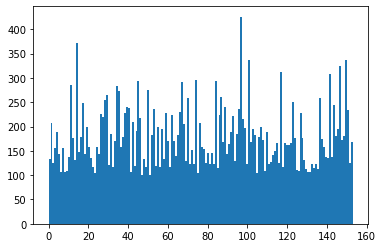

In [31]:

# gini index and average household income
reduced_demos = demographics_data[["zip", "SE_A14028_001", "SE_A14011_001"]]
reduced_demos["vacancy_rate"] = demographics_data["SE_A10001_001"].divide(demographics_data["SE_A10044_002"])
reduced_demos["income_to_homevalue"] = demographics_data["SE_A10036_001"].divide(demographics_data["SE_A14011_001"])
reduced_demos["renters_pct"] = demographics_data["SE_A10060_003"].divide(demographics_data["SE_A10001_001"])

null_counts = reduced_demos.isnull().sum()
print(null_counts[null_counts > 0])
reduced_demos = reduced_demos.dropna()
print(reduced_demos.shape)
#reduced_demos = StandardScaler().fit_transform(reduced_demos)

reduced_demos_no_zip = reduced_demos.drop("zip", axis=1)

clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=3, cluster_selection_method='leaf')
clusterer.fit(reduced_demos_no_zip)

labels = clusterer.labels_
unique_labels = set(labels)
print( " clusters: ", len(unique_labels), " and noise points ", (labels == -1).sum(), ", noise as : ", (labels == -1).sum()/len(labels))

label_sum = []

for k in unique_labels:
    label_sum.append((labels == k).sum())
    
non_noise = labels[labels != -1]

plt.hist(non_noise, bins=len(unique_labels)-1)
plt.show()

In [32]:
clusters = reduced_demos[['zip']]
clusters["cluster"] = labels
clusters.head()

C:\Users\winbase\Anaconda3\envs\mids\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,zip,cluster
0,601,-1
1,602,-1
2,603,10
3,606,-1
4,610,-1


So using just those statistics we can get some pretty reasonable clusters. Now let's join those up with the sales data.

In [48]:
sales_data = pd.read_csv("data/newdata/med_sale_price_yoy_no_pct.csv", delimiter="	")
sales_data.index = sales_data.index.astype(int)
sales_data = sales_data.rename(columns={"Region":"zip"})
#sales_data.set_index('zip')
sales_data = sales_data.fillna(0)
print(sales_data.head())

    zip  February 2016  March 2016  April 2016  May 2016  June 2016  \
0   501            0.0         0.0         0.0       0.0        0.0   
1  1005           15.4         5.7       -29.7     -24.0       33.7   
2  1010            0.0         0.0         0.0       0.0        0.0   
3  1031          705.0       612.0       -24.6     -24.6      -83.2   
4  1037            0.0         0.0       -23.9       0.0      102.7   

   July 2016  August 2016  September 2016  October 2016  ...  December 2019  \
0        0.0          0.0             0.0           0.0  ...            0.0   
1        8.6          5.7            -9.1          -4.1  ...            7.3   
2        0.0          0.0             0.0           0.0  ...            0.0   
3      -13.7         -3.3            -2.0          27.6  ...           43.9   
4      150.4        150.4             0.0           0.0  ...            0.0   

   January 2020  February 2020  March 2020  April 2020  May 2020  June 2020  \
0           0.0    

Now we get sales data for each of our clusters

In [50]:
cluster_sales = sales_data.merge(clusters, on="zip")
cluster_sales = cluster_sales.fillna(0)
cluster_sales.head()

,zip,February 2016,March 2016,April 2016,May 2016,June 2016,July 2016,August 2016,September 2016,October 2016,...,January 2020,February 2020,March 2020,April 2020,May 2020,June 2020,July 2020,August 2020,September 2020,cluster
0,1005,15.4,5.7,-29.7,-24.0,33.7,8.6,5.7,-9.1,-4.1,...,-4.3,6.3,-7.9,2.2,-4.4,12.4,-1.3,4.5,1.3,33
1,1010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29
2,1031,705.0,612.0,-24.6,-24.6,-83.2,-13.7,-3.3,-2.0,27.6,...,-13.8,70.9,162.0,126.9,-1.0,-37.8,-48.3,-51.1,681.4,68
3,1037,0.0,0.0,-23.9,0.0,102.7,150.4,150.4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-24.4,-14.5,17
4,1057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29


Now create a dataframe which contains the mean sales data across all months for each zipcode in the cluster

In [155]:
cluster_names = []
mean_yoy_by_cluster = pd.DataFrame()

for c in np.unique(cluster_sales["cluster"]):
    sub = cluster_sales[(cluster_sales['cluster'] == c)]
    sub_no_zip = sub.drop(columns=["cluster", "zip"])
    tmp_df = sub_no_zip.mean(1).to_frame()
    #tmp_df = tmp_df.transpose()
    tmp_df["cluster"] = c
    tmp_df["zip"] = sub["zip"]
    tmp_df.set_index("zip")
    mean_yoy_by_cluster = mean_yoy_by_cluster.append(tmp_df, ignore_index=True)

#we can't do this here because we need it later, but we will set the index to zip before doing the OLS
#mean_yoy_by_cluster = mean_yoy_by_cluster.set_index("zip")

print(mean_yoy_by_cluster[mean_yoy_by_cluster["cluster"] == 1].head())
mean_yoy_by_cluster[mean_yoy_by_cluster["cluster"] == 1].shape

             0  cluster   zip
1662  3.641071        1  1451
1663  4.171429        1  1742
1664  5.285714        1  1748
1665  1.098214        1  1770
1666  5.510714        1  1772


(192, 3)

Now we need to get the demographic data of some selected fields for each cluster

In [156]:

all_cluster_demos = pd.DataFrame()

# we'll just start with 1 to see if it works, can become all later

for c in np.unique(clusters["cluster"]):
    zip_codes_for_cluster = mean_yoy_by_cluster[mean_yoy_by_cluster["cluster"] == c]
    cluster_demographics = demographics_data[demographics_data['zip'].isin(zip_codes_for_cluster["zip"])]
    cluster_demographics = cluster_demographics[['zip', 'SE_B01001_003','SE_B01001_004', 'SE_A14001_014', 'SE_A14001_015', 'SE_A14001_016', 'SE_A14001_017']]
    cluster_demographics["cluster"] = c
    all_cluster_demos = all_cluster_demos.append(cluster_demographics, ignore_index=True)

all_cluster_demos = all_cluster_demos.set_index('zip')
print(all_cluster_demos.head())
all_cluster_demos[all_cluster_demos["cluster"] == 1].shape

      SE_B01001_003  SE_B01001_004  SE_A14001_014  SE_A14001_015  \
zip                                                                
1440           4684           8685          572.0          389.0   
1463           2324           5310          541.0          586.0   
1467             94            114           12.0            9.0   
1468            907           1788          184.0          129.0   
1475           2386           4283          560.0          374.0   

      SE_A14001_016  SE_A14001_017  cluster  
zip                                          
1440          280.0          270.0       -1  
1463          469.0          515.0       -1  
1467           11.0           33.0       -1  
1468          132.0           89.0       -1  
1475          252.0          135.0       -1  


(192, 7)

In [157]:
# now use zip as the index for the demographics
mean_yoy_by_cluster = mean_yoy_by_cluster.set_index("zip")

In [159]:
import statsmodels.api as sm

X = all_cluster_demos[all_cluster_demos["cluster"] == 1][['SE_B01001_003','SE_B01001_004', 'SE_A14001_014', 'SE_A14001_015', 'SE_A14001_016', 'SE_A14001_017']]
Y = mean_yoy_by_cluster[mean_yoy_by_cluster["cluster"] == 1][0]
# print(X)
# print(Y)

model = sm.OLS(Y, X).fit()
print(model.summary())

all_models = []

for c in np.unique(clusters["cluster"]):
    X = all_cluster_demos[all_cluster_demos["cluster"] == c][['SE_B01001_003','SE_B01001_004', 'SE_A14001_014', 'SE_A14001_015', 'SE_A14001_016', 'SE_A14001_017']]
    Y = mean_yoy_by_cluster[mean_yoy_by_cluster["cluster"] == c][0]
    model = sm.OLS(Y, X).fit()
    all_models.append({"cluster":c, "model":model})
    


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.214
Model:                            OLS   Adj. R-squared (uncentered):              0.189
Method:                 Least Squares   F-statistic:                              8.450
Date:                Mon, 07 Dec 2020   Prob (F-statistic):                    4.07e-08
Time:                        13:56:54   Log-Likelihood:                         -654.41
No. Observations:                 192   AIC:                                      1321.
Df Residuals:                     186   BIC:                                      1340.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [ ]:
rsq_adj = []
rsq = []
fstat = []

for m in all_models:
    rsq_adj.append(m["model"].rsquared_adj)
    rsq.append(m["model"].rsquared)
    fstat.append(m["model"].fvalue)
    
print(" our average rsq adjusted across all of our models is", np.average(rsq_adj))
print(" our average rsq across all of our models is", np.average(rsq))
print(" our average f stat across all of our models is", np.average(fstat))